# 1. Set up

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

import pandas as pd
import json
import zipfile
import os
import seaborn as sns
import random
import shutil
import time

from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, Model
from keras.applications import ResNet152V2
from keras.applications.resnet_v2 import preprocess_input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
import wandb

!mkdir output
!mkdir output/tmp-augmented-images/
random.seed(123)

2024-05-26 07:51:51.063692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 07:51:51.063805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 07:51:51.218714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Prepare dataset

In [2]:
!cp -r /kaggle/input/pneumonia-data/pneumonia_data /kaggle/working

# 3. Resampling data

In [3]:
def resample_data(move_from, move_to, cl, images_to_move=100):
  path = "./" + 'pneumonia_data'

  classes = os.listdir(path + move_from)

  cl += '/'
  curr_path = path + move_from + cl
  for _, _, files in os.walk(curr_path):
    random.shuffle(files)
    files_to_move = files[:images_to_move]
    for fn in files_to_move:
      shutil.move(curr_path + fn, path + move_to + cl + fn)
      #print('Moved ' + curr_path + fn)

  print('Resampled Images')

move_from, move_to = 'train/', 'test/'
#resample_data(move_from, move_to, 'NORMAL', 200)
# Training images
print('Number of COVID training images:')
!ls pneumonia_data/train/COVID-19/ | wc -l
print('Number of NORMAL training images:')
!ls pneumonia_data/train/Normal/ | wc -l
print('Number of PNEUMONIA training images:')
!ls pneumonia_data/train/Pneumonia// | wc -l
print()
# Validation images
print('Number of COVID training images:')
!ls pneumonia_data/val/COVID-19/ | wc -l
print('Number of NORMAL validation images:')
!ls pneumonia_data/val/Normal/ | wc -l
print('Number of PNEUMONIA validation images:')
!ls pneumonia_data/val/Pneumonia/ | wc -l
print()
# Test images
#resample_data('test/', 'val/', 'PNEUMONIA', 2690)
print('Number of COVID training images:')
!ls pneumonia_data/test/COVID_19/ | wc -l
print('Number of NORMAL test images:')
!ls pneumonia_data/test/Normal/ | wc -l
print('Number of PNEUMONIA test images:')
!ls pneumonia_data/test/Pneumonia/ | wc -l

Number of COVID training images:
1100
Number of NORMAL training images:
3025
Number of PNEUMONIA training images:
3871

Number of COVID training images:
171
Number of NORMAL validation images:
235
Number of PNEUMONIA validation images:
765

Number of COVID training images:
10
Number of NORMAL test images:
10
Number of PNEUMONIA test images:
20


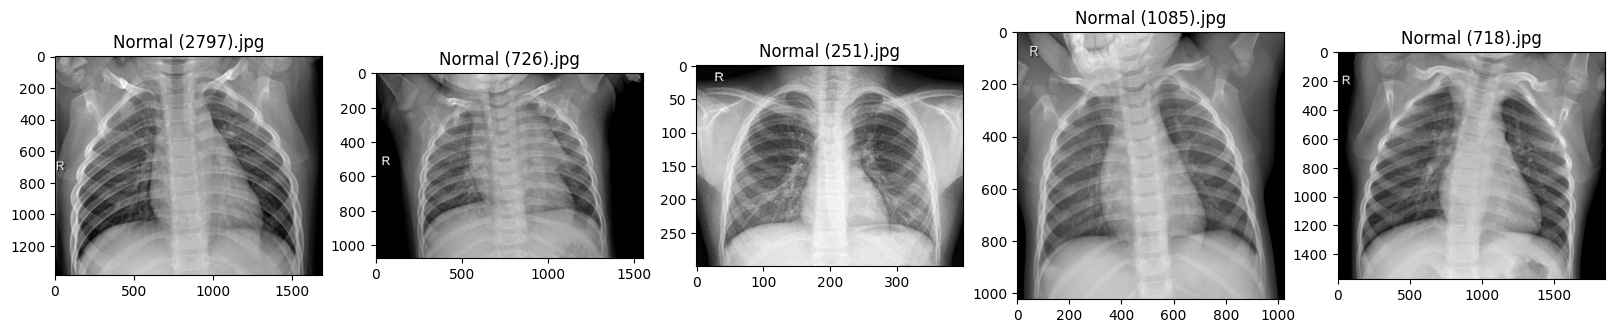

In [4]:
def viewImagesFromDir(path, num=5):
  #Display num random images from dataset. Rerun cell for new random images. The images are only single-channel

  img_paths_visualise = sorted(
    os.path.join(path, fname)
    for fname in os.listdir(path)
    if fname.endswith(".jpg")
)

  random.shuffle(img_paths_visualise)

  fig, ax = plt.subplots(1, num, figsize=(20, 10))
  for i in range(num):
    ax[i].imshow(Image.open(img_paths_visualise[i]))
    index = img_paths_visualise[i].rfind('/') + 1
    ax[i].title.set_text(img_paths_visualise[i][index:])

  fig.canvas.draw()
  time.sleep(1)

viewImagesFromDir('pneumonia_data/train/Normal/', num=5)

# 4. Assigning variables

In [5]:
base_dir = 'pneumonia_data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training covid 19 pictures
train_covid_dir = os.path.join(train_dir, 'COVID-19')
# Directory with our training normal pictures
train_normal_dir = os.path.join(train_dir, 'Normal')
# Directory with our training pneumonia pictures
train_pneumonia_dir = os.path.join(train_dir, 'Pneumonia')
# Directory with our validation covid 19 pictures
validation_covid_dir = os.path.join(validation_dir, 'COVID-19')
# Directory with our validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'Normal')
# Directory with our validation pneumonia pictures
validation_pneumonia_dir = os.path.join(validation_dir, 'Pneumonia')

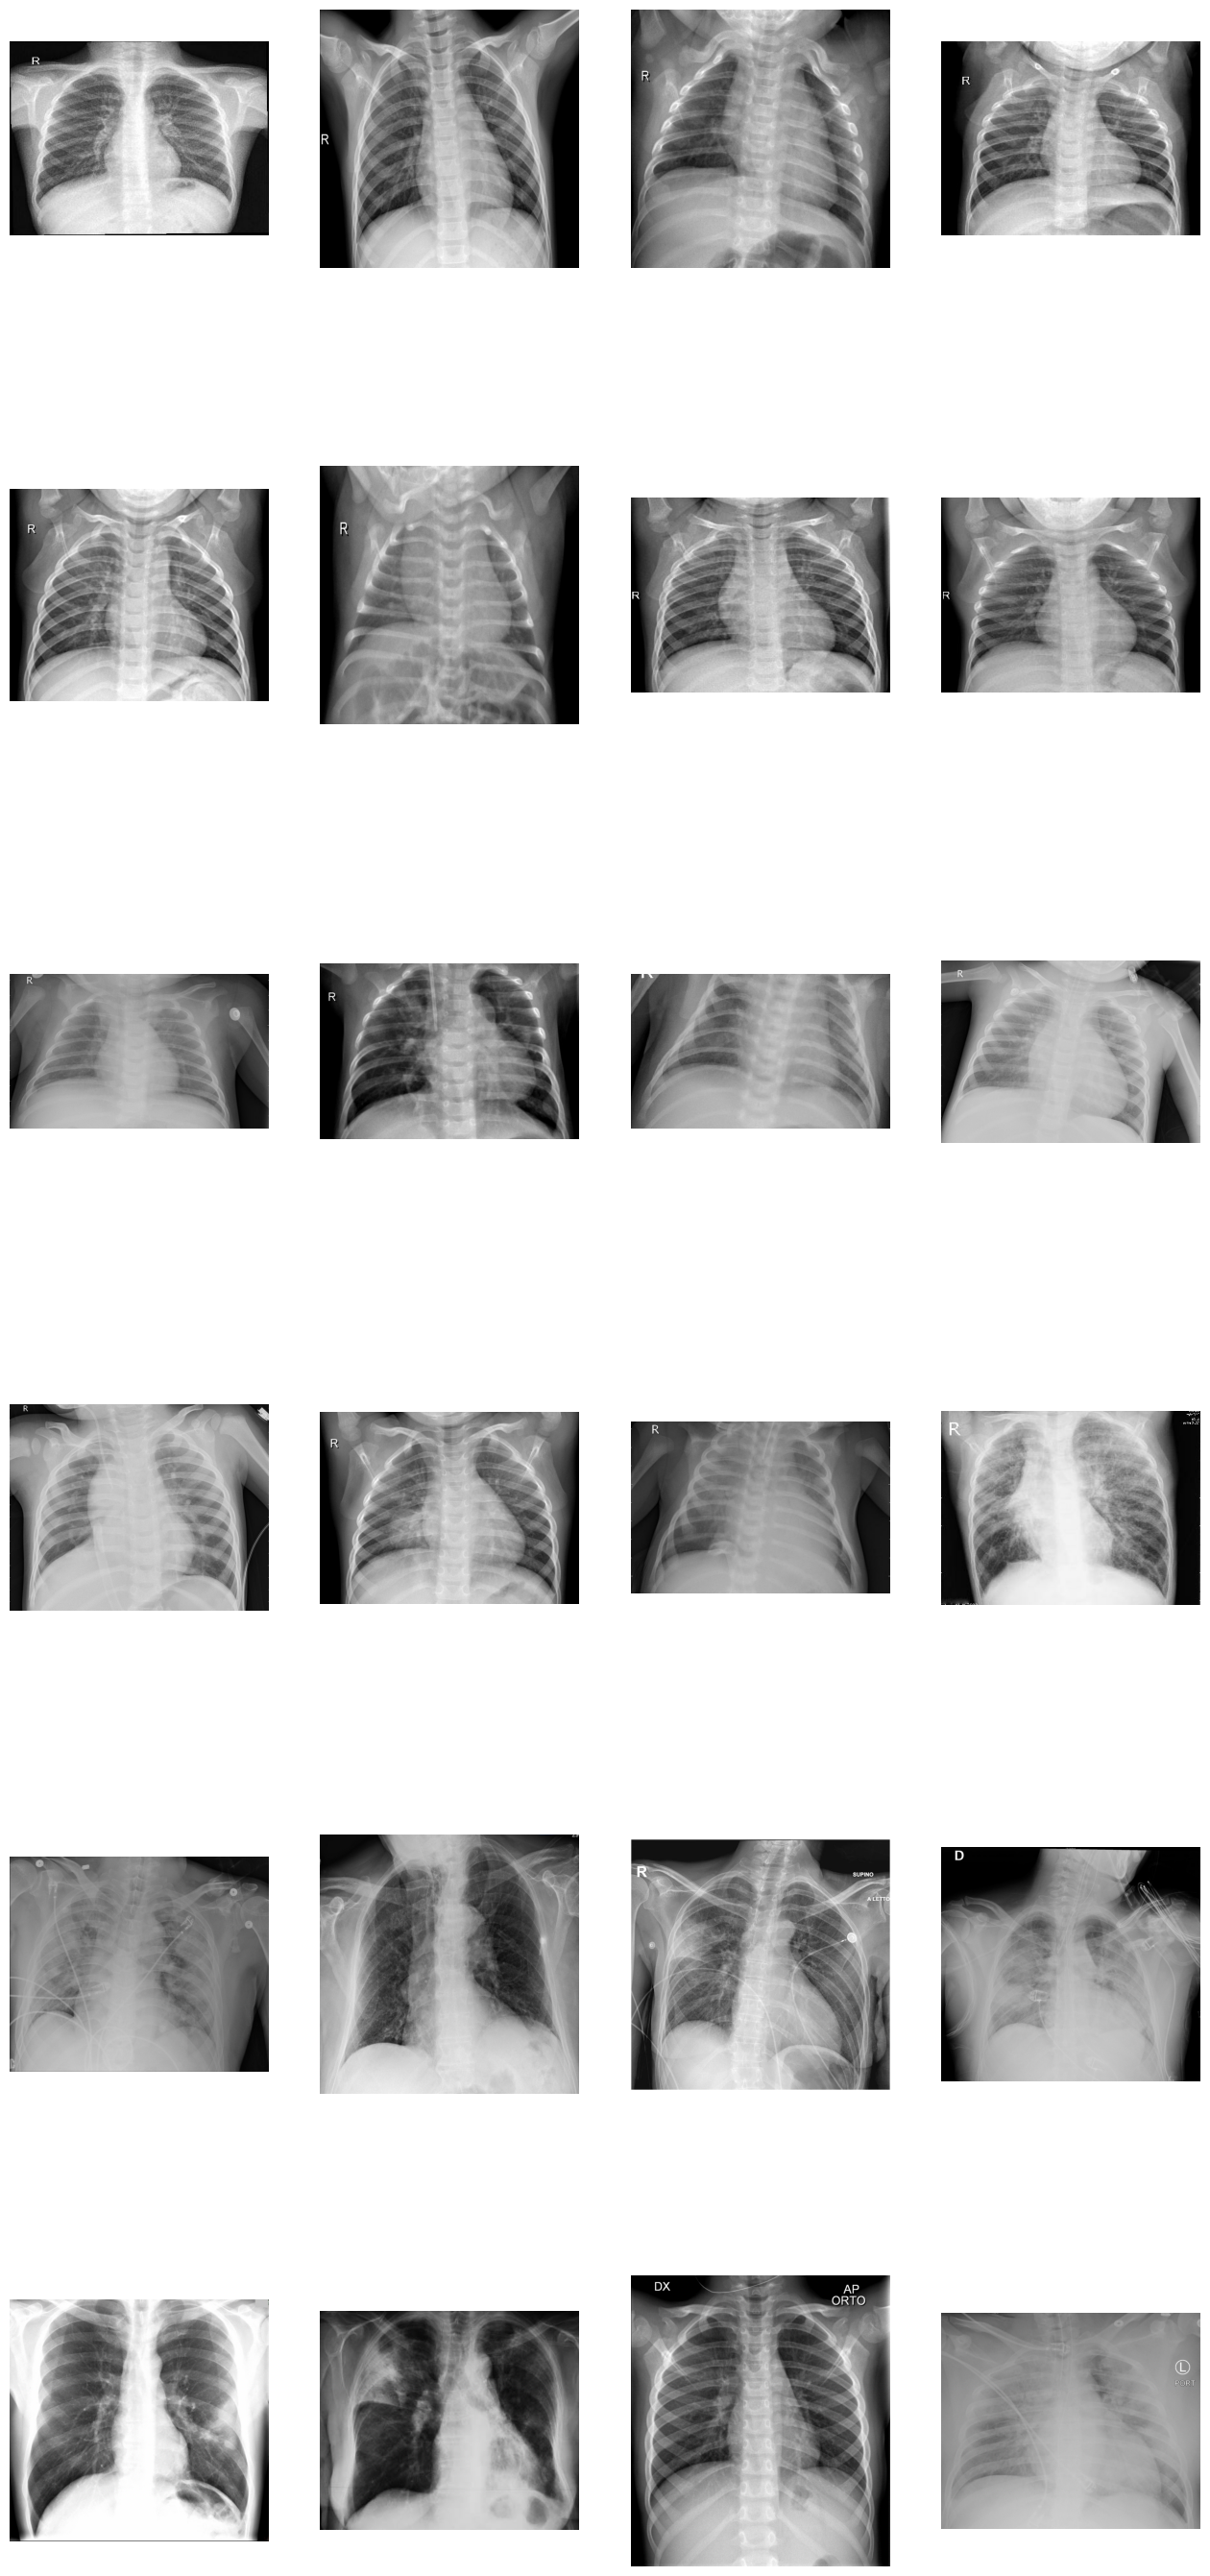

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 6
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*6)
pic_index = 100
train_covid_fnames = os.listdir( train_covid_dir)
train_normal_fnames = os.listdir( train_normal_dir )
train_pneumonia_fnames = os.listdir( train_pneumonia_dir )

next_covid_pix = [os.path.join(train_covid_dir, fname)
for fname in train_covid_fnames[ pic_index-8:pic_index]
]
next_normal_pix = [os.path.join(train_normal_dir, fname)
for fname in train_normal_fnames[ pic_index-8:pic_index]
]
next_pneumonia_pix = [os.path.join(train_pneumonia_dir, fname)
for fname in train_pneumonia_fnames[ pic_index-8:pic_index]
]
for i, img_path in enumerate(next_normal_pix+next_pneumonia_pix+next_covid_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# 5. Setting up generator

In [7]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [8]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 32, class_mode = 'categorical', target_size = (224, 224))
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size = 32, class_mode = 'categorical', target_size = (224, 224))

Found 7996 images belonging to 3 classes.
Found 1171 images belonging to 3 classes.


# 6. Training model

In [9]:
# Load ResNet152V2 model
base_model = ResNet152V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = layers.Flatten()(base_model.output)
#x = BatchNormalization()(x)  # Adding Batch Normalization
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation='softmax')(x)

#model = tf.keras.models.Model(base_model.input, x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

opt = tf.keras.optimizers.AdamW(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
# Train the model
resnet_history = model.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716710081.526316     141 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716710081.628411     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/250 ━━━━━━━━━━━━━━━━━━━━ 52s 730ms/step - acc: 0.8227 - loss: 0.5722 - top_k_categorical_accuracy: 1.0000

W0000 00:00:1716710210.915837     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - acc: 0.8379 - loss: 0.5126 - top_k_categorical_accuracy: 1.0000

W0000 00:00:1716710265.419204     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716710294.134574     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 256s 857ms/step - acc: 0.8381 - loss: 0.5119 - top_k_categorical_accuracy: 1.0000 - val_acc: 0.8360 - val_loss: 0.3933 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 705ms/step - acc: 0.9101 - loss: 0.2430 - top_k_categorical_accuracy: 1.0000 - val_acc: 0.8856 - val_loss: 0.2876 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 703ms/step - acc: 0.9189 - loss: 0.2289 - top_k_categorical_accuracy: 1.0000 - val_acc: 0.8523 - val_loss: 0.3449 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 180s 701ms/step - acc: 0.9223 - loss: 0.2150 - top_k_categorical_accuracy: 1.0000 - val_acc: 0.9009 - val_loss: 0.2448 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 180s 702ms/step - acc: 0.9331 - loss: 0.1887 - top_k_categorical_accuracy: 

In [11]:
# Unfreeze some layers and fine-tune with a lower learning rate
for layer in base_model.layers[-10:]:
    layer.trainable = True

opt = tf.keras.optimizers.AdamW(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

# Continue training
resnet_history_ft = model.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:34:46 37s/step - acc: 0.3750 - loss: 2.6498 - top_k_categorical_accuracy: 1.0000

W0000 00:00:1716713810.515155     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/250 ━━━━━━━━━━━━━━━━━━━━ 53s 718ms/step - acc: 0.8833 - loss: 0.3862 - top_k_categorical_accuracy: 1.0000

W0000 00:00:1716713936.145813     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - acc: 0.8960 - loss: 0.3351 - top_k_categorical_accuracy: 1.0000

W0000 00:00:1716713991.774013     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716714014.555749     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 242s 821ms/step - acc: 0.8962 - loss: 0.3346 - top_k_categorical_accuracy: 1.0000 - val_acc: 0.8557 - val_loss: 0.3619 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 183s 712ms/step - acc: 0.9508 - loss: 0.1409 - top_k_categorical_accuracy: 1.0000 - val_acc: 0.8659 - val_loss: 0.3390 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 182s 710ms/step - acc: 0.9481 - loss: 0.1429 - top_k_categorical_accuracy: 1.0000 - val_acc: 0.9300 - val_loss: 0.1813 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 185s 724ms/step - acc: 0.9566 - loss: 0.1287 - top_k_categorical_accuracy: 1.0000 - val_acc: 0.9172 - val_loss: 0.2376 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 185s 718ms/step - acc: 0.9578 - loss: 0.1201 - top_k_catego

# 7. Visualizing

In [12]:
model.save("pneumonia_detection.keras")
history = resnet_history_ft.history
history.keys()

dict_keys(['acc', 'loss', 'top_k_categorical_accuracy', 'val_acc', 'val_loss', 'val_top_k_categorical_accuracy', 'learning_rate'])

In [13]:
train_loss, val_loss = history['loss'], history['val_loss']
train_acc, val_acc = history['acc'], history['val_acc']
train_acc_top5 = history['top_k_categorical_accuracy']
val_acc_top5 = history['val_top_k_categorical_accuracy']

# Create a DataFrame to store the metrics
df = pd.DataFrame({
    'epoch': range(1, len(train_loss) + 1),
    'train/loss': train_loss,
    'train/accuracy_top1': train_acc,
    'train/accuracy_top5': train_acc_top5,
    'val/loss': val_loss,
    'val/accuracy_top1': val_acc,
    'val/accuracy_top5': val_acc_top5,
})

# Display the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv('/kaggle/working/training_report.csv', index=False)

    epoch  train/loss  train/accuracy_top1  train/accuracy_top5  val/loss  \
0       1    0.203387             0.930215                  1.0  0.361901   
1       2    0.147074             0.948224                  1.0  0.338951   
2       3    0.141206             0.949475                  1.0  0.181288   
3       4    0.127012             0.955978                  1.0  0.237621   
4       5    0.119932             0.956853                  1.0  0.213416   
5       6    0.114927             0.959605                  1.0  0.226044   
6       7    0.104160             0.961606                  1.0  0.128275   
7       8    0.109106             0.960480                  1.0  0.115696   
8       9    0.101867             0.965983                  1.0  0.229986   
9      10    0.099568             0.966608                  1.0  0.135368   
10     11    0.099939             0.963732                  1.0  0.139689   
11     12    0.092386             0.969110                  1.0  0.327404   

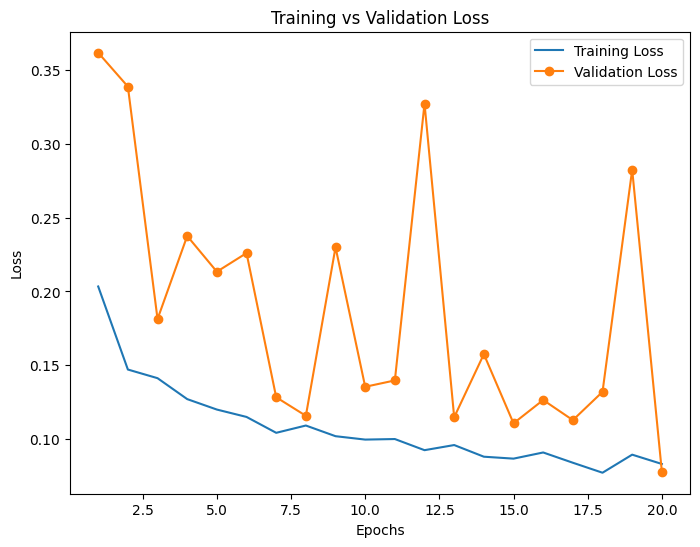

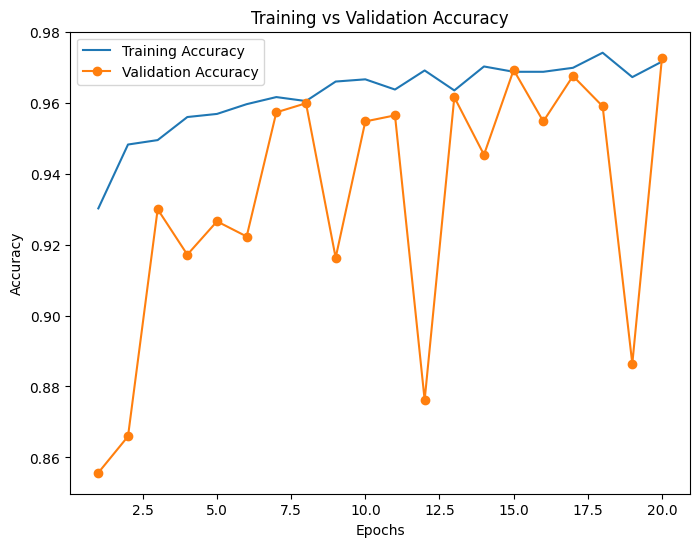

In [14]:
epoch_runs = [i+1 for i in range(20)]

# Plotting and saving Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epoch_runs, train_loss, label='Training Loss')
plt.plot(epoch_runs, val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_vs_validation_loss.png')
plt.show()

# Plotting and saving Training vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epoch_runs, train_acc, label='Training Accuracy')
plt.plot(epoch_runs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_vs_validation_accuracy.png')
plt.show()


# 8. Evaluation

In [15]:
saved_model = tf.keras.models.load_model("pneumonia_detection.keras")
test_dir = 'pneumonia_data/test'
# Assuming you have a separate test dataset stored in the variable test_dir
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=32, class_mode='categorical', target_size=(224,224))

# Evaluate the model on the test dataset
test_loss, test_acc, test_top_k_categorical_accuracy = saved_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Found 40 images belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/2 ━━━━━━━━━━━━━━━━━━━━ 14s 15s/step - acc: 0.9375 - loss: 0.1765 - top_k_categorical_accuracy: 1.0000

W0000 00:00:1716717563.403814     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 10s/step - acc: 0.9458 - loss: 0.1587 - top_k_categorical_accuracy: 1.0000
Test Loss: 0.14984168112277985
Test Accuracy: 0.949999988079071


W0000 00:00:1716717573.015970     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# 9. Confusion matrix

 2/37 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step

W0000 00:00:1716717584.125142     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 783ms/step


W0000 00:00:1716717612.311901     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[[ 28  26 117]
 [ 31  53 151]
 [106 158 501]]


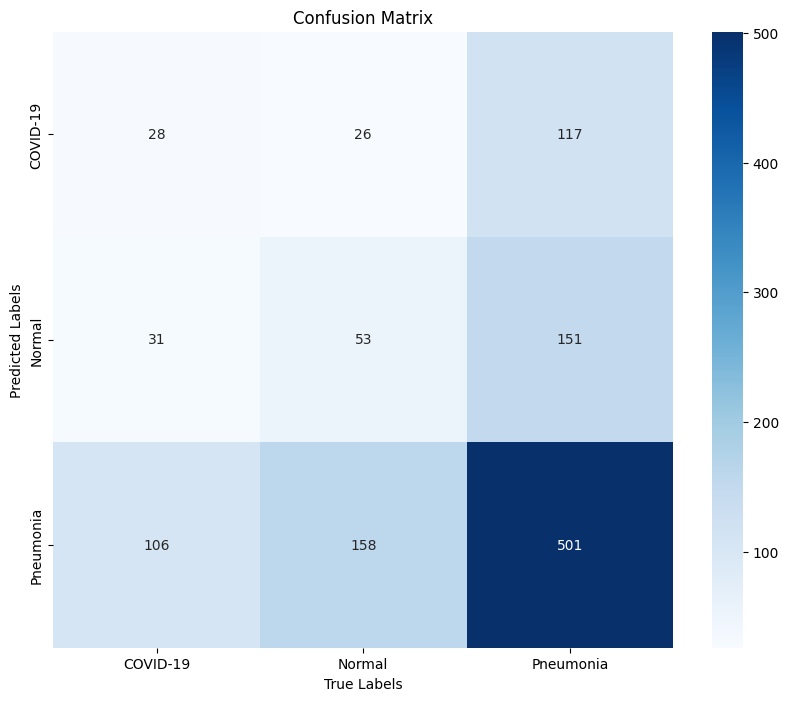

In [16]:
# Reset the validation generator to start from the beginning
#validation_generator.reset()

# Make predictions on the validation data
#predictions = saved_model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predictions = saved_model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

In [17]:
# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Extract metrics for each class
table1_data = {
    'Class': class_labels,
    'TN': [conf_matrix[i, i] for i in range(len(class_labels))],
    'FP': [conf_matrix[:, i].sum() - conf_matrix[i, i] for i in range(len(class_labels))],
    'FN': [conf_matrix[i, :].sum() - conf_matrix[i, i] for i in range(len(class_labels))],
    'TP': [conf_matrix.sum() - (conf_matrix[:, i].sum() + conf_matrix[i, :].sum() - conf_matrix[i, i]) for i in range(len(class_labels))]
}

# Create table 1
table1_df = pd.DataFrame(table1_data)

# Calculate additional metrics: accuracy, precision, recall, F1-score
#accuracy = [report[label]['accuracy'] for label in class_labels]
precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1_score = [report[label]['f1-score'] for label in class_labels]

# Calculate accuracy separately from the confusion matrix
accuracy = [(conf_matrix[i, i] + conf_matrix.sum() - (conf_matrix[:, i].sum() + conf_matrix[i, :].sum() - conf_matrix[i, i])) / conf_matrix.sum() for i in range(len(class_labels))]
# Create table 2
table2_data = {
    'Class': class_labels,
    'Accuracy': accuracy,
    'F1-Score': f1_score,
    'Precision': precision,
    'Recall': recall
}

table2_df = pd.DataFrame(table2_data)

# Print the tables
print("Table 1 - Confusion Matrix Metrics:")
print(table1_df)
print("\nTable 2 - Performance Metrics for Each Class:")
print(table2_df)
table1_df.to_csv('/kaggle/working/confusion_matrix_metrics.csv', index=False)
table2_df.to_csv('/kaggle/working/class_performance_metrics.csv', index=False)

Table 1 - Confusion Matrix Metrics:
       Class   TN   FP   FN   TP
0   COVID-19   28  137  143  863
1     Normal   53  184  182  752
2  Pneumonia  501  268  264  138

Table 2 - Performance Metrics for Each Class:
       Class  Accuracy  F1-Score  Precision    Recall
0   COVID-19  0.760888  0.166667   0.169697  0.163743
1     Normal  0.687447  0.224576   0.223629  0.225532
2  Pneumonia  0.545687  0.653194   0.651495  0.654902


In [18]:
from IPython.display import FileLink
FileLink(r'pneumonia_detection.keras')

/kaggle/working/pneumonia_detection.keras